In [ ]:
"""
Purpose: Implement Placeholders algorithm from "Learning Placeholders for Open-Set Recognition"
    and compare its performance to simple confidence thresholding on a logistic regression classifier.

Following https://builtin.com/data-science/guide-logistic-regression-tensorflow-20
"""

In [1]:
import numpy as np
from mnist import MNIST
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tqdm import tqdm

In [2]:
NUM_CLASSES = 10
NUM_FEATURES = 784

def load_dataset():
    mndata = MNIST('/Users/jmmar/Google Drive/School/ASU/Fall 2022/EEE 598/HW2/data/')
    mndata.gz = True  # allows the use of the .gz compressed files
    tensor = lambda data: tf.convert_to_tensor(data, dtype=tf.float32)
    X_train, y_train = map(tensor, mndata.load_training())
    X_test, y_test = map(tensor, mndata.load_testing())
    X_train = X_train/255.0
    X_test = X_test/255.0
    return X_train, y_train, X_test, y_test    

In [3]:
def plot_loss(train_losses, val_losses):
    iterations = list(range(len(train_losses)))
    plt.plot(iterations, train_losses, label='Train')
    plt.plot(iterations, val_losses, label='Validation')
    plt.xlabel('Iterations')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()
    plt.title('Loss While Training')
    plt.show()
    
def plot_acc(train_accs, val_accs):
    iterations = list(range(len(train_accs)))
    plt.plot(iterations, train_accs, label='Train')
    plt.plot(iterations, val_accs, label='Validation')
    plt.xlabel('Iterations')
    plt.ylabel('Classification Accuracy')
    plt.legend()
    plt.title('Accuracy While Training')
    plt.show()

In [74]:
class StandardLogisticRegressionModel(tf.Module):
    def __init__(self, num_classes, num_features, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.num_features = num_features
        self.w = tf.Variable(tf.zeros([num_features, num_classes]), name='weight')
        self.b = tf.Variable(tf.zeros([num_classes]), name='bias')
        
    def __call__(self, x):
        """Returns predicted class probabilities
        """
        return tf.nn.softmax(tf.matmul(x, self.w) + self.b)
    
    def predict(self, x):
        """Returns predicted class label(s)
        """
        return tf.argmax(self.__call__(x), axis=1)
    
    def train(self, x, y, loss_func, learning_rate):
        with tf.GradientTape() as tape:
            current_loss = loss_func(y, self.__call__(x), self)
        # Update using gradient descent
        dl_dw, dl_db = tape.gradient(current_loss, [self.w, self.b])
        model.w.assign_sub(learning_rate * dl_dw)
        model.b.assign_sub(learning_rate * dl_db)
    
# def ce_loss(y_true, y_pred, model):
#     """ Takes one-hot-encoded class labels
#     y_pred value are raw logit scores. The loss function calculates the softmax internally 
#     """
#     return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_true, y_pred))

def ce_loss(y_true, y_pred, model):
    """ Cross Entropy Loss.
    y_true: one-hot encoded class labels
    y_pred: class probabilities
    """
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

def ridge_ce_loss(y_true, y_pred, model, lam):
    regularizer_term = tf.reduce_sum(model.w ** 2)
    return ce_loss(y_true, y_pred, model) + lam * regularizer_term

def accuracy(y_true, y_pred):
    """y_true is the true class labels (not one-hot encoded) and y_pred are the predicted
    class labels (not class probabilities).
    """
    correct_preds = tf.equal(tf.cast(y_true, tf.int64), y_pred)
    return tf.reduce_mean(tf.cast(correct_preds, tf.float32))

def validation_split(X, y, val_size=.2):
    """Input are expected to me tensors.
    """
    tensor = lambda data: tf.convert_to_tensor(data, dtype=tf.float32)
    X_train, X_val, y_train, y_val = map(tensor, train_test_split(X.numpy(), y.numpy()))
    return X_train, X_val, y_train, y_val

def training_loop(model, X, y, num_epochs, loss, learning_rate):
    X_train, X_val, y_train, y_val = validation_split(X, y)
    y_train_one_hot = tf.one_hot(tf.cast(y_train, tf.int64), depth=model.num_classes)
    y_val_one_hot = tf.one_hot(tf.cast(y_val, tf.int64), depth=model.num_classes)
    weights = []
    biases = []
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    for epoch in tqdm(range(num_epochs)):
        model.train(X_train, y_train_one_hot, loss_func=loss, learning_rate=0.1)
        weights.append(model.w.numpy())
        biases.append(model.b.numpy())
        y_train_pred, y_val_pred = model(X_train), model(X_val)
        train_loss.append(loss(y_train_one_hot, y_train_pred, model))
        val_loss.append(loss(y_val_one_hot, y_val_pred, model))
        train_acc.append(accuracy(y_train, tf.argmax(y_train_pred, axis=1)))
        val_acc.append(accuracy(y_val, tf.argmax(y_val_pred, axis=1)))
    return weights, biases, train_loss, val_loss, train_acc, val_acc

In [5]:
X_train, y_train, X_test, y_test = load_dataset()


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:15<00:00, 19.07it/s]


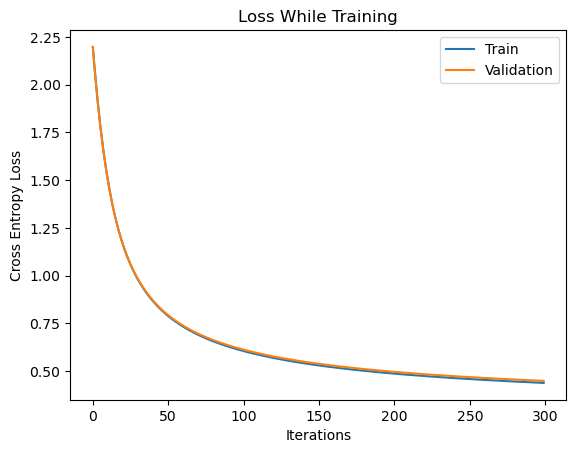

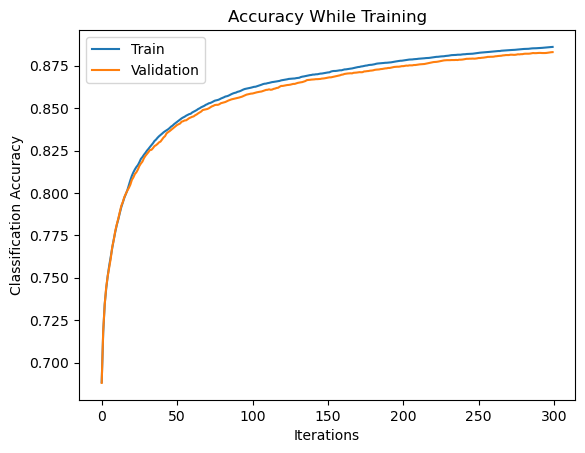

In [48]:
model = StandardLogisticRegressionModel(NUM_CLASSES, NUM_FEATURES)

weights, biases, train_loss, val_loss, train_acc, val_acc = training_loop(model, X_train, y_train, 300, ce_loss, .1)

plot_loss(train_loss, val_loss)
plot_acc(train_acc, val_acc)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:16<00:00, 17.67it/s]


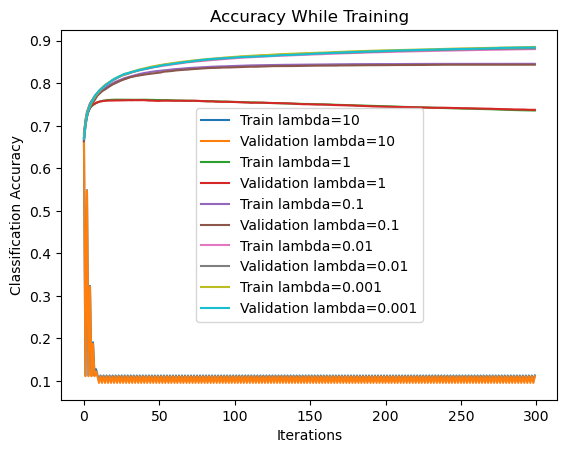

In [29]:
""" Experiment to see if ridge regression benefits accuracy. However, base model does not appear to overfit,
so I don't know that it is necessary.
"""

epochs = 300

for lam in [10, 1, .1, .01, .001]:
    model = StandardLogisticRegressionModel(NUM_CLASSES, NUM_FEATURES)
    loss = lambda *x: ridge_ce_loss(*x, lam)
    weights, biases, train_loss, val_loss, train_acc, val_acc = training_loop(model, X_train, y_train, epochs, loss, .1)
    plt.plot(list(range(epochs)), train_acc, label='Train lambda={}'.format(lam))
    plt.plot(list(range(epochs)), val_acc, label='Validation lambda={}'.format(lam))
plt.xlabel('Iterations')
plt.ylabel('Classification Accuracy')
plt.legend()
plt.title('Accuracy While Training')
plt.show()


In [76]:
""" 
Now we attempt open-set classicfication by training a logistic regression model on k 
classes (digits 0-8 for this dataset) and test on k+1. If all predicted class probabilities
are below a threshold, predict the open set.
"""

class OpenSetThresholdLogisticRegressionModel(StandardLogisticRegressionModel):
    def __init__(self, *args, threshold=.05, **kwargs):
        super().__init__(*args, **kwargs)
        self.threshold = threshold
        
    def predict(self, x):
        """ Returns the predicted class label. If all class probabilities fall below
        self.threshold, predicts the open-set and returns -1.
        """
        y_pred = self.__call__(x)
        highest_prob = tf.reduce_max(y_pred, axis=1)
        return tf.where(highest_prob < self.threshold, -1, tf.argmax(y_pred, axis=1))

def remove_classes_from_dataset(X, y, class_labels):
    """Removes samples from both X and y that correspond to classes given in class_labels
    class_labels: list of class_labels e.g. [3,4,9]
    y: tensor containing class labels (not yet one-hot encoded)
    """
    to_remove_mask = tf.reduce_all([y != label for label in class_labels], axis=0)
    y = tf.boolean_mask(y, to_remove_mask)
    X = tf.boolean_mask(X, to_remove_mask)
    return X, y

def modify_open_set_labels(y, open_set_class_labels):
    """Replaces class labels from the open set in y with -1
    """
    open_set_idx = tf.reduce_any([y == label for label in open_set_class_labels], axis=0)
    return tf.where(open_set_idx, -1, y)

def open_set_accuracy(y_true, y_pred):
    """ fraction of samples in the open set that are classified correctly.
    """
    y_true = tf.cast(y_true, tf.int64)
    open_set_idx = y_true == -1
    return accuracy(y_true[open_set_idx], y_pred[open_set_idx])

def closed_set_accuracy(y_true, y_pred):
    """ fraction of samples in the open set that are classified correctly.
    """
    y_true = tf.cast(y_true, tf.int64)
    closed_set_idx = y_true != -1
    return accuracy(y_true[closed_set_idx], y_pred[closed_set_idx])
    #return tf.reduce_sum(tf.equal(y_true[closed_set_idx], y_pred[closed_set_idx]))

def plot_open_closed_accuracy(all_acc, open_acc, closed_acc):
    plt.plot(threshold_value, all_acc, label='All class accuracy')
    plt.plot(threshold_value, open_acc, label='Open set accuracy')
    plt.plot(threshold_value, closed_acc, label='Closed set accuracy')
    plt.xlabel('Classification Probability Threshold')
    plt.ylabel('Classification Accuracy')
    plt.legend()
    plt.title('Effect of Threshold on Accuracy')
    plt.show()

In [55]:
X_train, y_train, X_test, y_test = load_dataset()

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:06<00:00, 48.84it/s]


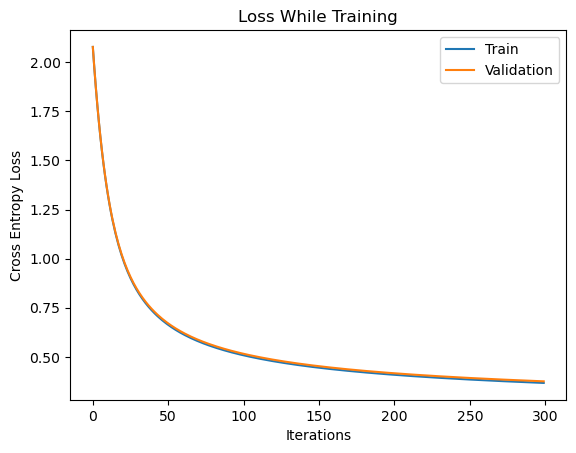

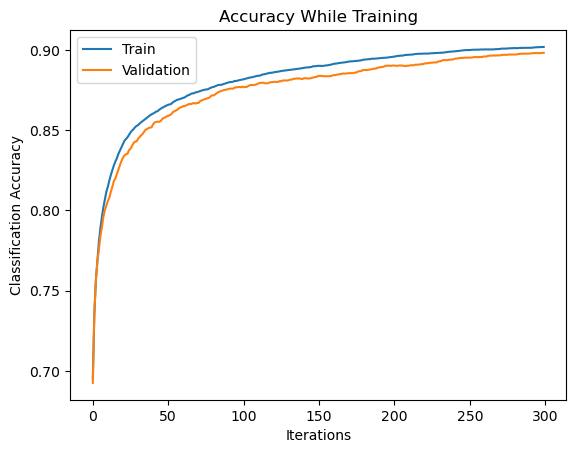

In [59]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set
open_set_class_labels = [9] 

X_train, X_val, y_train, y_val = validation_split(X_train, y_train)
X_train_closed, y_train_closed = remove_classes_from_dataset(X_train, y_train, open_set_class_labels)

# convert instances of class labels in the open set to -1
y_val_open = modify_open_set_labels(y_val, open_set_class_labels)

model = OpenSetThresholdLogisticRegressionModel(NUM_CLASSES - len(open_set_class_labels), NUM_FEATURES)

# train on closed set
weights, biases, train_loss, val_loss, train_acc, val_acc = training_loop(
    model, X_train_closed, y_train_closed, 300, ce_loss, .1
)

plot_loss(train_loss, val_loss)
plot_acc(train_acc, val_acc)

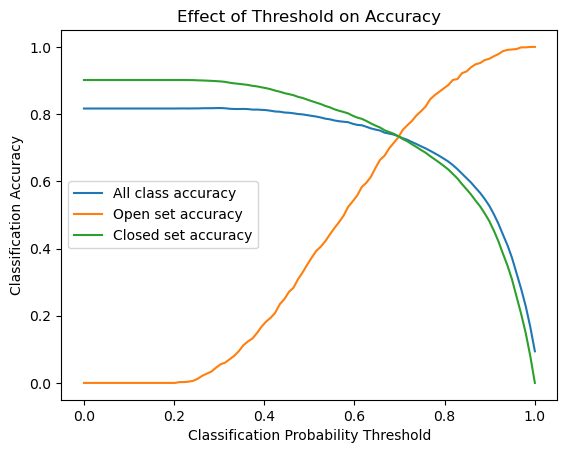

In [73]:
# See how the threshold value affects open-set accuracy
threshold_value = np.linspace(0, 1, 100)

total_acc = []
open_set_acc = []
closed_set_acc = []


for threshold in threshold_value:
    model.threshold = threshold
    y_pred = model.predict(X_val)
    total_acc.append(accuracy(y_val_open, y_pred))
    open_set_acc.append(open_set_accuracy(y_val_open, y_pred))
    closed_set_acc.append(closed_set_accuracy(y_val_open, y_pred))
    
plot_open_closed_accuracy(total_acc, open_set_acc, closed_set_acc)

In [83]:
""" Now that we have a baseline, we will implement the placeholders algorithm.
"""

class OpenSetPlaceholdersLogisticRegressionModel(StandardLogisticRegressionModel):
    def __init__(self, *args, num_placeholders, **kwargs):
        super().__init__(*args, **kwargs)
        self.num_placeholders = num_placeholders
        self.w_placeholder = tf.Variable(
            tf.zeros([self.num_features, num_placeholders]), name='placeholder_weight'
        )
        # override parent's bias vector with a new one with an additional element for
        # the dummy class
        self.b = tf.Variable(tf.zeros([self.num_classes + 1]), name='bias')
        
    def __call__(self, x):
        """ Take highest placeholder logit as dummy class prediction.
        """
        place_holder_logit = tf.reduce_max(tf.matmul(x, self.w_placeholder), axis=1)
        closed_set_logits = tf.matmul(x, self.w)
        all_logits = tf.concat([closed_set_logits, tf.expand_dims(place_holder_logit, 1)], axis=1)
        return tf.nn.softmax(all_logits + self.b)
        
    def predict(self, x):
        """ Returns the predicted class label. If predicted class is dummy class, return -1
        indicating prediction falls within the open set.
        """
        y_pred = self.__call__(x)
        y_pred_labels = tf.argmax(y_pred, axis=1)
        return tf.where(y_pred_labels == self.num_classes, -1, y_pred_labels)
    
def ce_loss_for_placeholders(y_true, y_pred, model, beta):
    loss = ce_loss(y_true, y_pred, model)
    # set each sample's predicted probability for the true class to zero
    y_pred_without_true_prob = tf.where(y_true == 1, 0, y_pred)
    # create a new y_true where the true label is the dummy class
    rows, cols = y_true.shape
    y_true_dummy = tf.concat([tf.zeros([rows, cols - 1]), tf.ones([rows, 1])], axis=1)
    loss += beta * ce_loss(y_true_dummy, y_pred_without_true_prob, model)
    return loss

In [108]:
def placeholder_training_loop_no_data_place_holders(model, X, y, num_epochs, loss, learning_rate):
    X_train, X_val, y_train, y_val = validation_split(X, y)
    # The "+ 1"s below add an additional column of zeros to the one-hot encodings for
    # the dummy class
    y_train_one_hot = tf.one_hot(tf.cast(y_train, tf.int64), depth=model.num_classes + 1)
    y_val_one_hot = tf.one_hot(tf.cast(y_val, tf.int64), depth=model.num_classes + 1)
    weights = []
    biases = []
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    for epoch in tqdm(range(num_epochs)):
        model.train(X_train, y_train_one_hot, loss_func=loss, learning_rate=0.1)
        weights.append(model.w.numpy())
        biases.append(model.b.numpy())
        y_train_pred, y_val_pred = model(X_train), model(X_val)
        train_loss.append(loss(y_train_one_hot, y_train_pred, model))
        val_loss.append(loss(y_val_one_hot, y_val_pred, model))
        train_acc.append(accuracy(y_train, tf.argmax(y_train_pred, axis=1)))
        val_acc.append(accuracy(y_val, tf.argmax(y_val_pred, axis=1)))
    return weights, biases, train_loss, val_loss, train_acc, val_acc

In [105]:
X, y, X_test, y_test = load_dataset()

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:24<00:00, 12.41it/s]


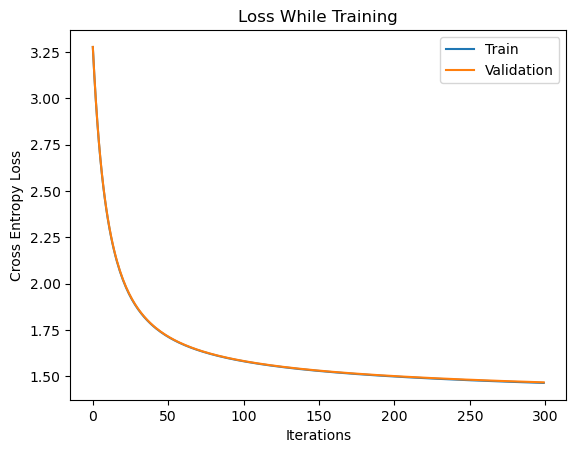

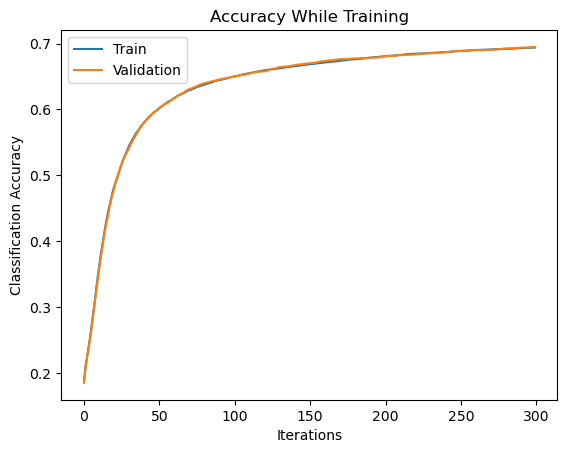

In [109]:
# train for closed set classification on 0-8, 9 is removed before training
# from the train set, but is left in the valdation set
open_set_class_labels = [9] 

X_train, X_val, y_train, y_val = validation_split(X, y)
X_train_closed, y_train_closed = remove_classes_from_dataset(X_train, y_train, open_set_class_labels)

# convert instances of class labels in the open set to -1
y_val_open = modify_open_set_labels(y_val, open_set_class_labels)

num_placeholders = 10

model = OpenSetPlaceholdersLogisticRegressionModel(
    NUM_CLASSES - len(open_set_class_labels), NUM_FEATURES, num_placeholders=num_placeholders
)

beta = .5
loss = lambda *x: ce_loss_for_placeholders(*x, beta)

# train on closed set
weights, biases, train_loss, val_loss, train_acc, val_acc = placeholder_training_loop_no_data_place_holders(
    model, X_train_closed, y_train_closed, 300, loss, .1
)

plot_loss(train_loss, val_loss)
plot_acc(train_acc, val_acc)

In [110]:
total_acc = []
open_set_acc = []
closed_set_acc = []

y_pred = model.predict(X_val)

print("total accuracy:      ", accuracy(y_val_open, y_pred))
print("open-set accuracy:   ", open_set_accuracy(y_val_open, y_pred))
print("closed-set accuracy: ", closed_set_accuracy(y_val_open, y_pred))

total accuracy:       tf.Tensor(0.72253335, shape=(), dtype=float32)
open-set accuracy:    tf.Tensor(0.9035263, shape=(), dtype=float32)
closed-set accuracy:  tf.Tensor(0.70237833, shape=(), dtype=float32)
